In [3]:
# Genetic algorithm for generating tile grids based on distribution-matching of isovists
# Begin by calculating the opennness histogram for a given image
# Create an initial population of random tile grids
# Optimize the population to minimize distribution distance of opennesss to the given image
# - Earth-mover distance? KL divergence (may not be good since the distribution support may not match)
# Mutation: change X% of the pixels randomly (10%?)
# Crossover: select pixels randomly from image A or image B, one-point crossover, two-point crossover

# OR use the isovists to inform WFC
# This is a pretty cool idea
# Asssuming that uncollapsed tiles follow the training distribution
# Each "raster line" contributes a histogram of possible lengths when it travels through partially unconstrained space
# Select (for example) one raster line per tile to track.
# After each tile is collapsed, update the histogram

# OR select a ray, and determine its length from the distribution of rays
# Conditional (?) on the direction of ray
# Select the ray based on the entropy of the ray
# Select the length of the ray based on the the current distribution?

In [4]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [36]:
import sys
sys.path.append("../..")

In [5]:
# What do we mean by "distribution of isovists"?
# - Per-pixel openness values * Simplest to implement + has a little bit of joint distribution encoded here
# - Per-ray ray lengths
# - Per-ray-direction openness values
# - Distribution of pairwise visible sets

In [6]:
#TODOs:
# Implement mutation + crossover
# Implement base maps
# Implement isovist histogram analysis
# Implement distribution distance on histograms

In [7]:
# u, v, u_w, v_w
from scipy.stats import wasserstein_distance

In [8]:
import time

In [25]:
from IPython.display import display, clear_output

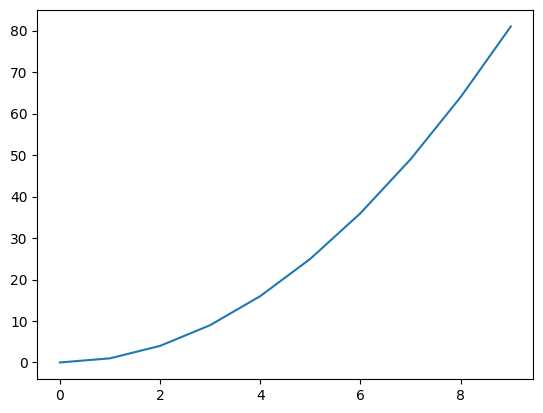

In [27]:
# Live Plotting Proof of Concept
xs = []
ys = []
fig = figure()
ax = fig.add_subplot(1,1,1)
for i in range(10):
    xs.append(i)
    ys.append(i * i)
    ax.cla()
    ax.plot(xs, ys)
    display(fig)
    clear_output(wait=True)
    time.sleep(0.5)

In [37]:
from world_rando.isovision import *

In [62]:
WIDTH = 16
HEIGHT = 16

In [65]:
import random

In [66]:
random.seed(0)

In [73]:
def mk_random_ind():
    z = np.zeros((WIDTH, HEIGHT), dtype=uint8)
    for i in iter2d(z):
        z[i] = random.randint(0,1)
    return z

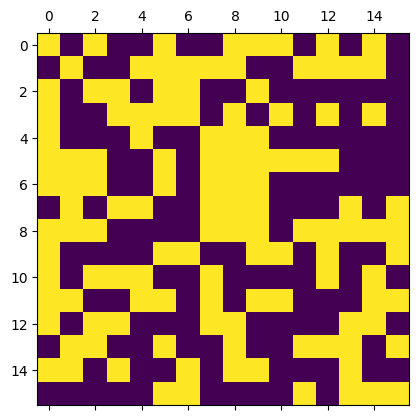

In [74]:
matshow(mk_random_ind())

In [69]:
target = np.zeros((WIDTH, HEIGHT), dtype=uint8)
center = Coord(WIDTH / 2, HEIGHT / 2)
for i in iter2d(target):
    if i.euclidean(center) < (WIDTH * 3 / 8) and i.euclidean(center) > (WIDTH * 1 / 8):
        target[i] = 0
    else:
        target[i] = 1

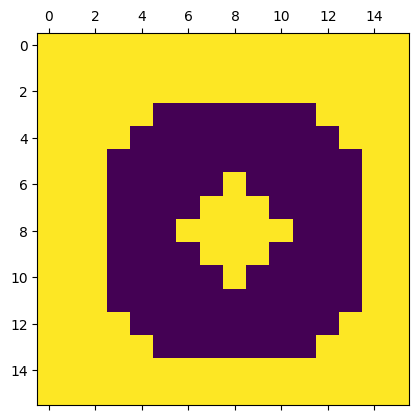

In [70]:
matshow(target)

In [111]:
#TODO: is it better to fix the total number of changes?
#TODO: try to maintain or push towards the same solid/air ratio as the target?
def mutate(ind):
    out = zeros_like(ind)
    for i in iter2d(ind):
        if random.random() < 0.2:
            if ind[i] == 1:
                out[i] = 0
            else:
                out[i] = 1
        else:
            out[i] = ind[i]
    return out

def linear_index(pt):
    return pt.y * WIDTH + pt.x

#TODO crossover across a random line
def one_point_crossover(ind1, ind2):
    cross = random.randint(0, WIDTH * HEIGHT)
    out = np.zeros_like(ind1)
    for i in iter2d(out):
        if linear_index(i) < cross:
            out[i] = ind1[i]
        else:
            out[i] = ind2[i]
    return out

In [118]:
from collections import namedtuple

In [ ]:
#TODO: speed up openness calculation by adjusting step size based on a precomputed distance map
def eval_individual():
    pass

In [121]:
Ind = namedtuple("Ind", ("data", "eval"))

def eval(i):
    if i.eval is None:
        i.eval = eval_individual(i.data)
    return i.eval

class GeneticAlg(object):

    def __init__(self, pop_size, mut_rate, mut, cross):
        self.pop = [Ind(mk_random_ind(), None) for _ in range(pop_size)]
        self.pop_size = pop_size
        self.mut_rate = mut_rate
        self.mut = mut
        self.cross = cross

    def mk_new_ind(self):
        p1, p2 = random.choices(self.pop, 2)
        child = cross(p1, p2)
        if random.random() < mut_rate:
            child = mut(child)
        return child

    def rebuild(self):
        n_to_make = self.pop_size - len(self.pop)
        children = []
        for _ in range(n_to_make):
            child = self.mk_new_ind()
            children.append(child)
        self.pop = self.pop + children

    def eval_mean(self):
        return np.mean([eval(i) for i in pop])

    def mk_new_pop(self):
        sorted_pop = sorted(self.pop, key = lambda x: eval(x))
        # Keep the best half
        self.pop = sorted_pop[pop_size / 2]
        self.rebuild()
        